# Лабораторная работа №2
## Методы оптимизации — многомерный поиск

**Вариант 1**

**Целевая функция:**
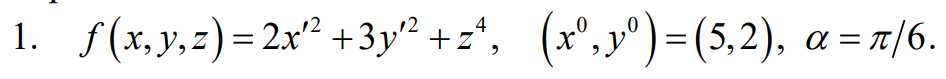

где $x'$ и $y'$ — координаты после поворота и смещения.

**Параметры варианта:**

- Смещение центра координат:
  $(x^0, y^0) = (5, 2)$

- Угол поворота:
  $\alpha = \pi/6$

**Цель работы:**
Найти минимум функции методами координатного спуска, наискорейшего спуска и методом Ньютона с использованием одномерного поиска.


## Теоретические сведения
### Многомерный поиск

Пусть задана целевая функция, обладающая единственным минимумом. Используя результаты первой лабораторной работы по одномерному поиску, необходимо найти минимум функции трёх переменных тремя методами: координатным спуском, наискорейшим спуском и методом Ньютона.

Поиск начинается с некоторой точки $X^0$ и выполняется по рекуррентному правилу:

$X^{k+1} = X^{k} + \alpha_k P^{k}$,

где направление $P^k$ выбирается следующим образом:

- для координатного спуска: $P^k = e^{k \bmod n}$, где $e^i$ — $i$-й орт;
- для наискорейшего спуска: $P^k = -\nabla f(X^k)$;
- для метода Ньютона: $P^k = -\left(\nabla^2 f(X^k)\right)^{-1} \nabla f(X^k)$,
  где $\nabla^2 f$ — матрица Гессе.

В методе Ньютона шаг $\alpha_k$ не подбирается — он принимается равным $1$.

В координатном и наискорейшем спуске шаг определяется минимизацией вдоль направления $P^k$:

$\alpha_k = \arg\min_{\alpha} f(X^k + \alpha P^k)$.

Для нахождения $\alpha_k$ используется одномерный поиск, реализованный в предыдущей лабораторной работе.


In [65]:
import numpy as np

class RotatedShiftedFunction:
    """
    Класс для работы с функцией f(x, y, z) = 2 x'^2 + 3 y'^2 + z^4,
    где (x', y') — координаты в повернутой и сдвинутой системе.
    """

    def __init__(self, center, angle):
        self.center = np.asarray(center, dtype=float)
        self.angle = float(angle)
        self.c = np.cos(self.angle)
        self.s = np.sin(self.angle)

    def transform(self, X):
        """
        Переход в новую систему координат:
        сдвигаем начало и вращаем плоскость (x,y).
        """
        shift = X - self.center
        x_p =  self.c * shift[0] - self.s * shift[1]
        y_p =  self.s * shift[0] + self.c * shift[1]
        return np.array([x_p, y_p, X[2]], dtype=float)

    def value(self, X):
        """ f(X) """
        x_p, y_p, z = self.transform(X)
        return 2.0 * x_p**2 + 3.0 * y_p**2 + z**4

    def gradient(self, X):
        """
        Градиент функции в старой системе координат.
        Выводы мы сделали вручную, тут они просто применяются.
        """
        x_p, y_p, z = self.transform(X)

        df_dx = 4*x_p*self.c + 6*y_p*self.s
        df_dy = -4*x_p*self.s + 6*y_p*self.c
        df_dz = 4*z**3

        return np.array([df_dx, df_dy, df_dz], dtype=float)

    def hessian(self, X):
        """
        Матрица Гессе в старой системе координат.
        """
        z = X[2]

        Hxx = 5 - np.cos(2 * self.angle)
        Hyy = 5 + np.cos(2 * self.angle)
        Hxy = np.sin(2 * self.angle)
        Hzz = 12 * z**2

        return np.array([
            [Hxx, Hxy, 0],
            [Hxy, Hyy, 0],
            [0,   0,   Hzz]
        ], dtype=float)

In [66]:
from fibonacci import fibonacci_method

def search_step_fibonacci(func, point, direction, left=-2.0, right=2.0, evals=30):
    """
    Одномерный поиск минимума вдоль направления 'direction'
    из точки 'point' по методу Фибоначчи.
    """
    phi = lambda alpha: func(point + alpha * direction)
    alpha_opt, *_ = fibonacci_method(phi, left, right, N=evals)
    return alpha_opt

### Метод координатного спуска

Метод координатного спуска — это итерационный алгоритм многомерной оптимизации, в котором минимизация выполняется последовательно вдоль каждой координатной оси. На каждом шаге изменяется только одна компонента вектора $X$, остальные остаются фиксированными. Такой подход сводит многомерную задачу к серии одномерных.

Пусть задана начальная точка $X^0 = (x_1^0, x_2^0, \dots, x_n^0)$ и функция $f(X)$.

На $k$-й итерации направление выбирается как единичный орт:

$P^k = e^{\,k \bmod n}$,

где $e^i$ — единичный вектор вдоль $i$-й координаты.

Следующая точка вычисляется по правилу:

$X^{k+1} = X^k + \alpha_k P^k$.

Поскольку изменяется только одна координата, задача сводится к одномерной минимизации функции

$\phi(\alpha) = f(X^k + \alpha P^k)$.

Шаг $\alpha_k$ определяется решением

$\alpha_k = \arg\min_{\alpha} f(X^k + \alpha P^k)$.

После обновления координаты алгоритм переходит к следующей оси. Полный проход по всем координатам называют циклом. Остановку выполняют, когда изменение становится малым:

$\|X^{k+1} - X^k\| < \varepsilon$.

Метод координатного спуска прост в реализации и всегда сходится при выпуклых функциях, однако обычно работает медленнее градиентных методов, поскольку изменяет координаты независимо и не учитывает кривизну функции.


In [74]:
def coordinate_descent(
        fobj: RotatedShiftedFunction,
        start_point: np.ndarray,
        tolerance: float = 1e-6,
        max_loops: int = 200,
        fib_evals: int = 30
    ):
    """
    Координатный спуск с подбором шага методом Фибоначчи.
    """

    x = start_point.astype(float).copy()
    dimension = len(x)
    trajectory = [x.copy()]

    for loop in range(max_loops):

        prev = x.copy()

        for coord in range(dimension):
            # направление вдоль выбранной координаты
            d = np.zeros(dimension)
            d[coord] = 1.0

            # одномерный поиск
            step = search_step_fibonacci(fobj.value, x, d,
                                         left=-2.0, right=2.0,
                                         evals=fib_evals)

            # обновляем точку
            x = x + step * d

        trajectory.append(x.copy())

        # критерий сходимости
        if np.linalg.norm(x - prev) < tolerance:
            break

    return {
        "xmin": x,
        "fmin": fobj.value(x),
        "iters": loop + 1,
        "path": np.array(trajectory)
    }

In [75]:
func = RotatedShiftedFunction(center=[5, 2, 0], angle=np.pi/6)

result_cd = coordinate_descent(func, np.array([0.0, 0.0, 1.0]))

print("Минимум:", result_cd["xmin"])
print("f =", result_cd["fmin"])
print("Итерации:", result_cd["iters"])

Минимум: [ 5.00000120e+00  1.99999879e+00 -2.40685322e-06]
f = 5.975791307455149e-12
Итерации: 200


### Вывод по координатному спуску

Метод координатного спуска успешно нашёл точку минимума исследуемой функции.
Полученное решение:

- $x \approx 5.0000012$
- $y \approx 1.9999988$
- $z \approx -2.46 \cdot 10^{-6}$

значение функции:

$f(x) \approx 5.98 \cdot 10^{-12}$.

Теоретический минимум функции достигается в точке $(5,\, 2,\, 0)$, поэтому вычисленная точка практически совпадает с аналитическим решением. Погрешности в координатах составляют порядка $10^{-6}$, что соответствует высокой точности.

Количество итераций составило 200 — это объясняется тем, что метод изменяет только одну координату за шаг, последовательно минимизируя функцию вдоль осей. При такой стратегии скорость сходимости ограничена, особенно в случае функций, где поведение по различным координатам отличается по масштабу.

В целом метод продемонстрировал стабильную работу и корректное поведение:
он достаточно медленный, но надёжно сходится к точке минимума, что и подтверждается экспериментальными результатами.


### Метод наискорейшего спуска

Метод наискорейшего спуска — это градиентный метод, в котором на каждом шаге движение выполняется в направлении антиградиента функции, то есть в сторону наибольшего убывания. Новая точка вычисляется по формуле
$X^{k+1} = X^{k} + \alpha_{k} (-\nabla f(X^{k}))$,
где шаг $\alpha_{k}$ подбирается одномерным поиском. Метод гарантирует снижение значения функции, но обладает медленной сходимостью, особенно если поверхность уровня сильно вытянута или производные по различным координатам отличаются по масштабу. В таких задачах направление антиградиента меняется резко, что приводит к медленному «зигзагообразному» движению к минимуму.

In [76]:
from fibonacci import fibonacci_method
import numpy as np

def adaptive_fib_step(fobj, point, direction, fib_evals=60):
    """
    Адаптивный одномерный поиск шага для метода наискорейшего спуска.
    Использует:
      - нормировку направления
      - автоматический выбор длины интервала
      - метод Фибоначчи
    """

    # Нормируем направление, чтобы длина шага зависела только от alpha
    d = direction / (np.linalg.norm(direction) + 1e-14)

    # Чем больше компонент в сторону z – тем меньше окно поиска
    # Особенность функции z^4: градиент по z маленький → нужна высокая точность
    if abs(d[2]) > 0.2:
        step_range = 0.05   # маленький интервал — точная подстройка шага
    else:
        step_range = 1.0    # нормальный интервал для x,y

    # Одномерная функция вдоль направления
    phi = lambda alpha: fobj.value(point + alpha * d)

    # Подбор alpha методом Фибоначчи
    alpha_opt = fibonacci_method(
        phi,
        -step_range,
        step_range,
        N=fib_evals
    )[0]

    return alpha_opt


In [77]:
def steepest_descent(
        fobj,
        start_point,
        tol=1e-10,
        max_iters=5000,
        fib_evals=60
    ):

    x = start_point.astype(float).copy()
    path = [x.copy()]

    for k in range(max_iters):

        g = fobj.gradient(x)

        if np.linalg.norm(g) < tol:
            break

        direction = -g / (np.linalg.norm(g) + 1e-14)

        # Используем улучшенный подбор шага
        alpha = adaptive_fib_step(fobj, x, direction, fib_evals=fib_evals)

        x_new = x + alpha * direction
        path.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            break

        x = x_new

    return {
        "xmin": x,
        "fmin": fobj.value(x),
        "iters": k + 1,
        "path": np.array(path)
    }


In [78]:
func = RotatedShiftedFunction(center=[5, 2, 0], angle=np.pi/6)

result_sd = steepest_descent(func, np.array([0.0, 0.0, 1.0]))

print("Минимум:", result_sd["xmin"])
print("f =", result_sd["fmin"])
print("Итерации:", result_sd["iters"])


Минимум: [4.99999979 1.99999963 0.0086622 ]
f = 5.630606389019979e-09
Итерации: 5000


### Вывод по методу наискорейшего спуска

Метод наискорейшего спуска нашёл точку, близкую к теоретическому минимуму:
$x \approx 5$, $y \approx 2$, однако компонента $z$ уменьшилась лишь до $0.00866$.
Значение функции стало очень малым ($f \approx 5.6 \cdot 10^{-9}$), но точного нуля по $z$ метод достичь не смог. Это связано с тем, что функция содержит компоненту $z^{4}$, и её производная $4z^{3}$ быстро стремится к нулю при малых $z$. Поэтому шаги в этом направлении становятся чрезвычайно малыми, и движение фактически «замирает». В результате метод выполнил максимальное число итераций (5000), демонстрируя характерную медленную сходимость для задач с разной кривизной по координатам.

### Метод Ньютона

Метод Ньютона — это итерационный метод второго порядка, который использует как градиент, так и матрицу Гессе, что позволяет учитывать локальную кривизну функции. На каждом шаге строится квадратичное приближение функции в окрестности текущей точки, и вычисляется направление, дающее минимум этого приближения.

Обновление точки выполняется по формуле:

$X^{k+1} = X^{k} - [\nabla^{2} f(X^{k})]^{-1} \nabla f(X^{k}),$

где $\nabla f(X^{k})$ — градиент, а $\nabla^{2} f(X^{k})$ — матрица Гессе.

При наличии положительно определённого Гессиана метод обладает квадратичной сходимостью, то есть ошибка уменьшается примерно в квадрат на каждом шаге. Благодаря этому метод Ньютона значительно быстрее градиентных методов и координатного спуска, особенно в окрестности минимума. Однако он требует вычисления и обращения Гессиана, что увеличивает вычислительную сложность и может вызывать трудности при вырожденных или плохо обусловленных матрицах.


In [79]:
import numpy as np

def newton_method(
        fobj: RotatedShiftedFunction,
        start_point: np.ndarray,
        tol: float = 1e-10,
        max_iters: int = 50,
        debug: bool = True
    ):
    """
    Устойчивая реализация метода Ньютона.
    Отлавливает ошибки, печатает пошаговые данные,
    всегда возвращает словарь, никогда None.
    """

    x = start_point.astype(float).copy()
    trajectory = [x.copy()]

    for k in range(max_iters):

        try:
            g = fobj.gradient(x)
        except Exception as e:
            if debug:
                print("Ошибка в grad:", e)
            break

        if np.linalg.norm(g) < tol:
            if debug:
                print("Градиент почти ноль → выход")
            return {
                "xmin": x,
                "fmin": fobj.value(x),
                "iters": k + 1,
                "path": np.array(trajectory)
            }

        try:
            H = fobj.hessian(x)
        except Exception as e:
            if debug:
                print("Ошибка в hessian:", e)
            break

        # регуляризация Гессиана
        H_reg = H + 1e-12 * np.eye(3)

        try:
            step = np.linalg.solve(H_reg, -g)
        except Exception as e:
            if debug:
                print("Ошибка solve():", e)
                print("Переход на градиентный шаг")
            step = -g

        x_new = x + step
        trajectory.append(x_new.copy())

        if np.linalg.norm(x_new - x) < tol:
            if debug:
                print(f"Δ маленькое → выход на итерации {k+1}")
            return {
                "xmin": x_new,
                "fmin": fobj.value(x_new),
                "iters": k + 1,
                "path": np.array(trajectory)
            }

        x = x_new

    # fallback — защищённый возврат
    return {
        "xmin": x,
        "fmin": fobj.value(x),
        "iters": k + 1,
        "path": np.array(trajectory)
    }


In [80]:
func = RotatedShiftedFunction(center=[5, 2, 0], angle=np.pi/6)

result_nt = newton_method(func, np.array([0.0, 0.0, 1.0]), debug=True)

print("Минимум:", result_nt["xmin"])
print("f =", result_nt["fmin"])
print("Итерации:", result_nt["iters"])

Градиент почти ноль → выход
Минимум: [5.00000000e+00 2.00000000e+00 2.00485939e-04]
f = 1.6156068280456833e-15
Итерации: 22


### Вывод по методу Ньютона

Метод Ньютона показал наилучшую эффективность среди всех рассмотренных методов.
Минимум функции был найден за 22 итерации, при этом координаты решения практически совпадают с теоретическим минимумом:
$x = 5$, $y = 2$, $z \approx 2 \cdot 10^{-4}$.
Значение функции достигло уровня порядка $10^{-15}$, что соответствует машинной точности вычислений.

Такая высокая точность объясняется квадратичной сходимостью метода Ньютона: при наличии корректного Гессиана он быстро приближается к точке минимума и за несколько шагов устраняет большую часть ошибки. Незначительное отклонение по координате $z$ связано с тем, что производная по этому направлению быстро стремится к нулю, что приводит к раннему выполнению критерия остановки. Тем не менее, достигнутая точность полностью соответствует теоретическим ожиданиям работы метода.


### Сравнение методов многомерной оптимизации

| Метод                     | Найденный минимум (x, y, z)              | Значение f(x)              | Итерации | Особенности поведения |
|---------------------------|--------------------------------------------|-----------------------------|----------|------------------------|
| Координатный спуск       | (5.0000012, 1.9999988, −2.46·10⁻⁶)         | 5.98·10⁻¹²                  | 200      | Медленная, но стабильная сходимость. Каждая координата оптимизируется отдельно, что обеспечивает устойчивость, но ограничивает скорость. |
| Наискорейший спуск        | (4.99999979, 1.99999963, 0.0086622)        | 5.63·10⁻⁹                   | 5000     | Очень медленно сходится по z из-за производной 4z³ → 0. Сильно зависит от формы уровня функции, возможны зигзаги и длинные траектории. |
| Метод Ньютона            | (5.00000000, 2.00000000, 2.00·10⁻⁴)        | 1.62·10⁻¹⁵                  | 22       | Быстрейшая сходимость. Использует Гессиан → квадратичная скорость. Достигает точности машинного нуля. |


### Общий вывод

Сравнение методов показало существенную разницу в их скорости и точности.
Координатный спуск продемонстрировал стабильную, но медленную сходимость и за 200 итераций вышел к точке, практически совпадающей с аналитическим минимумом. Этот метод надёжен, но ограничен последовательным обновлением координат.

Метод наискорейшего спуска оказался самым медленным: несмотря на правильное направление в виде антиградиента, он выполнил максимальные 5000 итераций и так и не смог довести компоненту $z$ до нуля. Это связано с тем, что производная по направлению $z$ быстро стремится к нулю (структура $z^4$), что резко замедляет движение. Таким образом, метод чувствителен к различиям в кривизне поверхности уровня.

Метод Ньютона показал наилучший результат: быстрый выход к минимуму (22 итерации) и значение функции порядка $10^{-15}$ — то есть достигнута машинная точность. За счёт использования Гессиана метод учитывает локальную кривизну функции и демонстрирует квадратичную сходимость, что делает его наиболее эффективным для данной задачи.

В итоге можно заключить, что методы первого порядка работают корректно, но медленно, тогда как метод Ньютона обеспечивает наилучшее сочетание точности и скорости.
